In [ ]:
## Since the GeoSquare V2.0 is not open source to the public yet (2024-06-30), here, we use a demo to 
## simulate the storage and retrieval, and other interactive behavior for webservices in this application case.

In [51]:
## Implementation of sentence embedding and similarity calculation methods based on BAAI/bge-m3.
# These methods assist in computing similarities to match nodes from the GEE knowledge template with corresponding Web Services.

import torch
from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F

model_name = 'BAAI/bge-m3'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

device = 'cpu'
model.to(device)

def generate_embedding(text):
    input = tokenizer(text, return_tensors='pt', padding=True, truncation=True).to(device)
    with torch.no_grad():
        output = model(**input)
        embedding = output.last_hidden_state[:,0,:]
        embedding = torch.nn.functional.normalize(embedding, p=2, dim=1)
        return embedding
    
def find_topk_similar(embedding, embeddings, k=5):
    embedding = embedding
    similarities = F.cosine_similarity(embedding, embeddings, dim=1)
    _, indices = torch.topk(similarities, k=k)
    
    return indices

Modeling Process extracted from GEE knowledge template landslide_susceptility_evaluation.xml


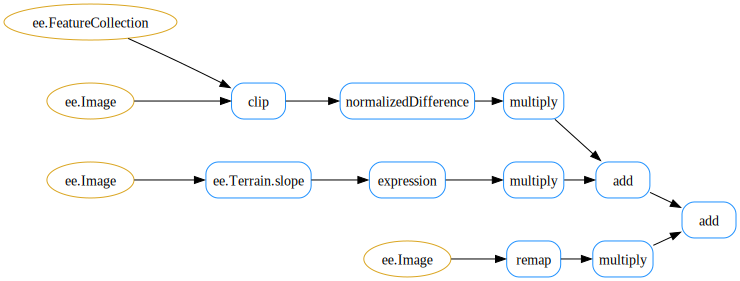

In [50]:
# Visualization of the modeling process derived from the "landslide_susceptibility_evaluation" knowledge template.

import xml.etree.ElementTree as ET
from graphviz import Digraph
from IPython.display import display

# Path to the XML file
file_path = r'data\landslide_susceptility_evaluation.xml'

# Parsing the XML file
tree = ET.parse(file_path)
root = tree.getroot()

# Creating a directed graph using Graphviz
dot = Digraph(comment='Modeling Process', engine='dot') 
dot.attr(rankdir='LR') 
dot.attr('graph', nodesep='0.6', ranksep='0.4')  # Adjusting node and rank separation


# Storage for IDs of nodes that are considered significant for the process visualization
significant_node_ids = []
significant_node_labels = []
significant_edges = []

# Extracting nodes from XML
for node in root.findall(".//ServiceNode/Node"):
    node_id = node.get('id')
    node_type = node.get('type')
    node_label = node.text.strip() if node.text else f'Node {node_id}'
    
    # Set colors and shapes based on node type
    if node_label in ['ee.Feature', 'ee.FeatureCollection', 'ee.Image','ee.ImageCollection', 'ee.Geometry']:
        color = '#DAA520'
        shape = 'ellipse' 
        style = 'filled, rounded'
        fillcolor = 'white'
    elif node_type == 'eeFunction':
        color = '#1E90FF'
        shape = 'box'  
        style = 'filled, rounded'
        fillcolor = 'white'
    else:
        color = 'black'
        shape = 'box'
        style = 'solid'
        fillcolor = 'white'
    
    # Adding only significant nodes (excluding nodes containing 'ee.List' or 'Export' in their labels)
    if 'ee.List' not in node_label and 'Export' not in node_label and node_type != 'literal':
        dot.node(node_id, label=node_label, shape=shape, style=style, color=color, fillcolor=fillcolor)
        significant_node_ids.append(node_id)  # Recording the node ID
        significant_node_labels.append(node_label)

# Extracting relationships from XML
for relation in root.findall(".//Relationship/Relation"):
    source_id = relation.get('sourceNodeId')
    target_id = relation.get('targetNodeId')
    
    # Adding edges only between significant nodes
    if source_id in significant_node_ids and target_id in significant_node_ids:
        dot.edge(source_id, target_id)
        significant_edges.append((source_id, target_id))

print('Modeling Process extracted from GEE knowledge template landslide_susceptility_evaluation.xml')
# Displaying the graph in Jupyter Notebook
display(dot)


GEE API node '2' (label: 'ee.Image') from the knowledge template is recognized as a raster input.
Identified mapping webservice 'Slope' for GEE API node '3' (label: 'ee.Terrain.slope') from the knowledge template.
Identified mapping webservice 'Reclassify' for GEE API node '4' (label: 'expression') from the knowledge template.
Identified mapping webservice 'Times' for GEE API node '6' (label: 'multiply') from the knowledge template.
GEE API node '11' (label: 'ee.Image') from the knowledge template is recognized as a raster input.
GEE API node '27' (label: 'ee.FeatureCollection') from the knowledge template is recognized as a vector input.
Identified mapping webservice 'Clip' for GEE API node '28' (label: 'clip') from the knowledge template.
Identified mapping webservice 'NDVI' for GEE API node '29' (label: 'normalizedDifference') from the knowledge template.
Identified mapping webservice 'Times' for GEE API node '31' (label: 'multiply') from the knowledge template.
Identified mapping w

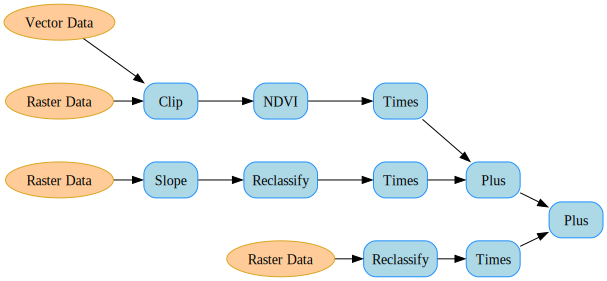

In [52]:
## This script illustrates how research can adapt the modeling process described above to develop a landslide susceptibility evaluation model.
# This adaptation involves replacing nodes in the original modeling process with geospatial web services or other tools outside the Google Earth Engine (GEE) environment.
# Here is an example demonstrating this adaptation.

## The script simulates the transition from the GEE modeling process to a WebService-based approach utilizing both ArcGIS and GEE.
## It should be noted that toolboxes in ArcPy can be published as REST API/SOAP/OGC WebServices, and GEE APIs can also be encapsulated as Web Services.
## For additional information, please refer to the following resources:
## - https://enterprise.arcgis.com/en/server/latest/publish-services/windows/what-is-a-geoprocessing-service.htm
## - https://pro.arcgis.com/en/pro-app/latest/help/analysis/geoprocessing/share-analysis/publishing-geoprocessing-service-in-arcgis-pro.htm
## - Liang, Jianyuan, et al. "WS4GEE: Enhancing geospatial web services and geoprocessing workflows by integrating the Google Earth Engine." Environmental Modelling & Software 161 (2023): 105636.

## For demonstration purposes, this example uses ArcGIS geoprocessing services.
# A list of ArcGIS toolboxes (ArcGIS geoprocessing services) are published as Web Services, with their summaries and links from GEE recorded in data\WebServices.csv.
# The BAAI/bge-m3 model is employed as the similarity evaluation algorithm.
# Note, for this example, only a few toolboxes match the GEE APIs, while there are other toolboxes that serve as disturbance items.

import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F

model_name = 'BAAI/bge-m3'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
embeddings_dict = torch.load(r'data\webservices.pth')
keys = list(embeddings_dict.keys())
embeddings_list = [embeddings_dict[key] for key in keys]
embeddings_tensor = torch.cat(embeddings_list)

csv_file_path = r'D:\Work\Data\Paper_Projects\GEEKnowledgeTemplate\demo\template4WebService\data\GEE_APIs.csv'

# Load the CSV file
df = pd.read_csv(csv_file_path)
node_details = {}

# Find matches and retrieve descriptions
for label, node_id in zip(significant_node_labels, significant_node_ids):
    match = df[(df['full_name'] == label) | (df['short_name'] == label)]
    if not match.empty:
        description = match['description'].values[0]
        node_details[node_id] = {'label': label, 'description': description}

# List of labels to exclude from embedding generation
vector_mapping_apis = ['ee.Feature', 'ee.FeatureCollection', 'ee.Geometry']
raster_mapping_apis = ['ee.Image', 'ee.ImageCollection']
# Iterating over the node details
for node_id, details in node_details.items():
    label = details['label']
    description = details['description']
    
    # Check if the label is not in the excluded list
    if label not in vector_mapping_apis and label not in raster_mapping_apis:
        # If not, process the description to generate embeddings
        cur_embedding = generate_embedding(description)
        index = find_topk_similar(cur_embedding, embeddings_tensor)[0]
        # Optionally store or process the embedding result
        print(f"Identified mapping webservice '{keys[index]}' for GEE API node '{node_id}' (label: '{label}') from the knowledge template.")
        node_details[node_id]["mapping"] = keys[index]
    elif label in vector_mapping_apis:
        node_details[node_id]["mapping"] = "Vector Data"
        print(f"GEE API node '{node_id}' (label: '{label}') from the knowledge template is recognized as a vector input.")
    else:
        node_details[node_id]["mapping"] = "Raster Data"
        print(f"GEE API node '{node_id}' (label: '{label}') from the knowledge template is recognized as a raster input.")

# Visualize the referenced workflow mapped to the ArcGIS WebService.
dot = Digraph(comment='ArcGIS Workflow', engine='dot') 
dot.attr(rankdir='LR') 
dot.attr('graph', nodesep='0.6', ranksep='0.4')  # Adjusting node and rank separation

# Extracting nodes from XML
for node_id in node_details.keys():   
    node = node_details[node_id]
    # Set colors and shapes based on node type
    if node['mapping'] == "Vector Data" or node['mapping'] == "Raster Data":
        color = '#DAA520'
        shape = 'ellipse' 
        style = 'filled, rounded'
        fillcolor = '#ffcc99'
    else:
        color = '#1E90FF'
        shape = 'box'  
        style = 'filled, rounded'
        fillcolor = '#add8e6'
    
    dot.node(node_id, label=node['mapping'], shape=shape, style=style, color=color, fillcolor=fillcolor)

# Extracting relationships from XML
for relation in significant_edges:
    source_id = relation[0]
    target_id = relation[1]
    
    # Adding edges only between significant nodes
    if source_id in node_details.keys() and target_id in node_details.keys():
        dot.edge(source_id, target_id)

# Displaying the graph in Jupyter Notebook
print("All GEE-related nodes have been matched with WebServices, which are generated from ArcGIS toolboxes. Please refer to the workflow in the ArcGIS Model Builder for implementation or continue running the WebService.")
display(dot)
